In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# df = pd.read_csv('extracted_data1.csv')
df = pd.read_csv('test_data.csv')

In [5]:
df.shape

(6116, 32)

In [6]:
df.drop(['credit_amount',
         'subscription_type_y'], axis=1, inplace=True)

In [7]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        df[col].fillna('Unknown', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   jobma_catcher_id               6116 non-null   int64  
 1   org_type                       6116 non-null   float64
 2   jobma_catcher_industry         6116 non-null   object 
 3   jobma_catcher_type             6116 non-null   int64  
 4   is_premium                     6116 non-null   float64
 5   jobma_catcher_sub_accounts     6116 non-null   int64  
 6   jobma_catcher_is_deleted       6116 non-null   object 
 7   jobma_verified                 6116 non-null   int64  
 8   subscription_status            6116 non-null   int64  
 9   interview_rate                 6116 non-null   float64
 10  live_interview_credit          6116 non-null   float64
 11  pre_recorded_credit            6116 non-null   float64
 12  credit_value                   6116 non-null   i

In [9]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == np.float64:
            df[col] = df[col].fillna(0.0)
        elif df[col].dtype == object:
            df[col] = df[col].fillna('Unknown')
    return df

# Data Encoding

In [11]:
label_encoders = {}
label_col = ['jobma_catcher_industry', 'org_type']

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders = le_col

    return df

In [12]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Pipeline

In [14]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('scaler', StandardScaler())# Needs attention to improve model
])

In [15]:
''' Visualizing the Pipeline '''
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x0000028483250220>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x0000028483250D60>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x0000028483251440>)),
                ('scaler', StandardScaler())])

# Fit Pipeline

In [17]:
X = df

In [18]:
X_transformed = pipeline.fit_transform(X)

In [19]:
type(X)

pandas.core.frame.DataFrame

In [20]:
type(X_transformed)

numpy.ndarray

In [21]:
X_df = pd.DataFrame(X_transformed)

In [22]:
X_df.columns

RangeIndex(start=0, stop=30, step=1)

In [23]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

In [24]:
type(X_tensor)

torch.Tensor

In [25]:
len(X_tensor)

6116

# Dataset Class

In [27]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
X_data = CustomDataset(X_tensor)

# DataLoader

In [30]:
BATCH_SIZE = 8

In [31]:
dataloader = DataLoader(X_data, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
len(X_data)

6116

In [33]:
len(dataloader)

765

# Autoencoder

In [35]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

**FLOW 1**

Model's encoder(embeddings) ----->  DEC's Input1

In [37]:
X_df.shape[1]

30

In [38]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [39]:
''' Important Parameters '''

learning_rate = 0.001
epochs = 20

In [40]:
''' Loss Function and Optimizer '''

cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [41]:
torch.manual_seed(42)

model_1.train()
model_1.to(device)

for epoch in range(epochs):
    epoch_total_loss = 0

    for batch_X in dataloader:
        batch_X = batch_X.to(device)

        # Forward pass
        encoded, decoded = model_1(batch_X)

        # Reconstruction Loss
        mse_loss = mse_loss_function(decoded, batch_X)

        # Similarity Loss using randomly shuffled batch
        # Get how many samples are in this batch
        batch_size = encoded.shape[0]
        # Create target labels (1 means we want vectors to be similar)
        target_labels = torch.ones(batch_size, device=device)

        # Shuffle the encoded vectors randomly
        permuted_indices = torch.randperm(batch_size, device=device)
        encoded_shuffled = encoded[permuted_indices]

        # Calculate Cosine Embedding Loss on original vs shuffled
        cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)

        # Total Loss
        total_loss = mse_loss + cosine_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss += total_loss.item()

    # Average loss over all batches in the epoch
    training_loss = epoch_total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f}')


Epoch 1/20 | Training Loss: 0.61688
Epoch 2/20 | Training Loss: 0.47763
Epoch 3/20 | Training Loss: 0.39769
Epoch 4/20 | Training Loss: 0.34088
Epoch 5/20 | Training Loss: 0.27363
Epoch 6/20 | Training Loss: 0.25244
Epoch 7/20 | Training Loss: 0.21285
Epoch 8/20 | Training Loss: 0.18075
Epoch 9/20 | Training Loss: 0.15140
Epoch 10/20 | Training Loss: 0.15166
Epoch 11/20 | Training Loss: 0.15907
Epoch 12/20 | Training Loss: 0.13989
Epoch 13/20 | Training Loss: 0.15400
Epoch 14/20 | Training Loss: 0.11347
Epoch 15/20 | Training Loss: 0.09931
Epoch 16/20 | Training Loss: 0.07943
Epoch 17/20 | Training Loss: 0.12829
Epoch 18/20 | Training Loss: 0.13781
Epoch 19/20 | Training Loss: 0.08172
Epoch 20/20 | Training Loss: 0.08917


# Clustering

In [43]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [44]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [45]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

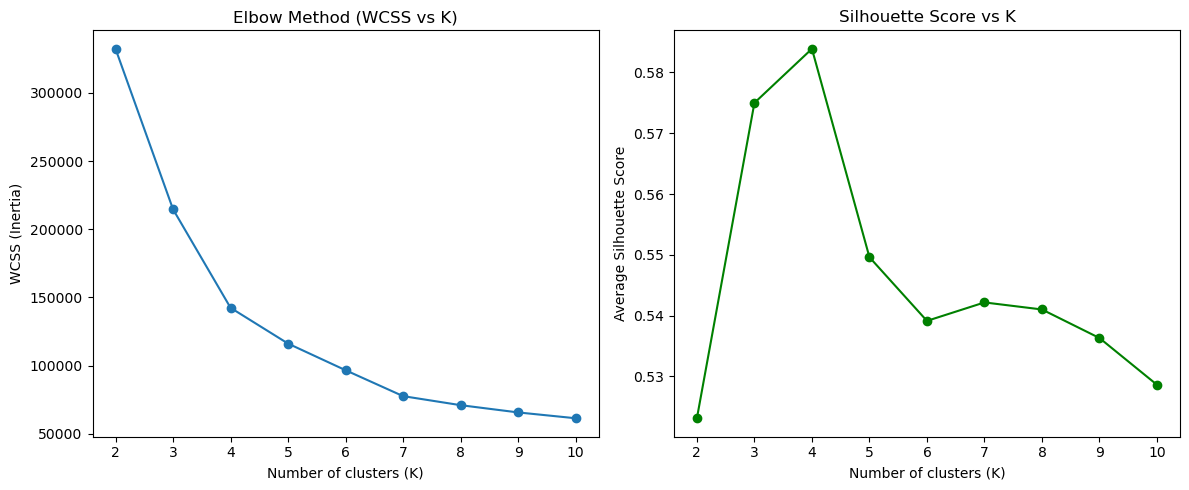

In [46]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [47]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=50)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

**FLOW 2**

KMeans Cluster_Centers(Centroids) ----->  DEC's Input2

In [49]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [50]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [51]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=1e-4)

In [52]:
''' Training Loop '''
torch.manual_seed(42)
dec.train()
num_epochs = 20

for epoch in range(num_epochs):
    for batch in dataloader:
        x = batch.to(device)

        # Forward pass
        q, z = dec(x)

        # Target distribution
        p = target_distribution(q)

        # Compute loss
        loss = kl_loss(q.log(), p)

        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.0438
Epoch 2/20, Loss: 0.0372
Epoch 3/20, Loss: 0.0179
Epoch 4/20, Loss: 0.0646
Epoch 5/20, Loss: 0.0573
Epoch 6/20, Loss: 0.0185
Epoch 7/20, Loss: 0.0354
Epoch 8/20, Loss: 0.0076
Epoch 9/20, Loss: 0.0038
Epoch 10/20, Loss: 0.0091
Epoch 11/20, Loss: 0.0099
Epoch 12/20, Loss: 0.0102
Epoch 13/20, Loss: 0.0703
Epoch 14/20, Loss: 0.0026
Epoch 15/20, Loss: 0.0093
Epoch 16/20, Loss: 0.0027
Epoch 17/20, Loss: 0.0105
Epoch 18/20, Loss: 0.0034
Epoch 19/20, Loss: 0.0198
Epoch 20/20, Loss: 0.0094


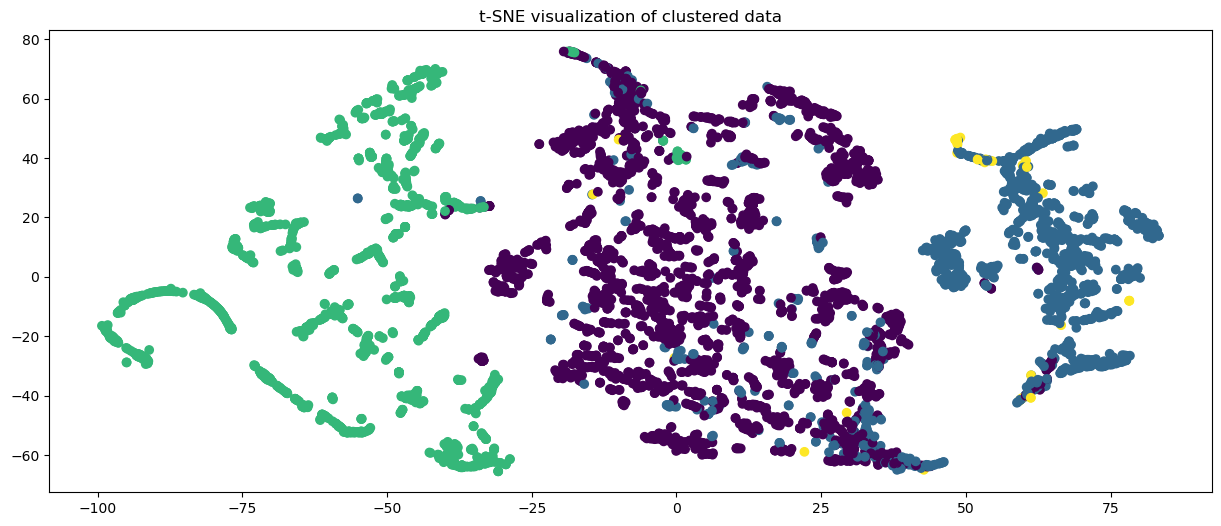

In [53]:
''' Visualizing the Clusters '''

dec.eval()
with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_ids, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [54]:
# ''' Visualizing the Clusters '''

# tsne = TSNE(n_components=2, random_state=42)
# latent_2d = tsne.fit_transform(latent_np)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=preds, palette='tab10', s=30, edgecolor='k')
# plt.title("Clustered Latent Space (t-SNE)")
# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [55]:
# dec.eval()
# with torch.no_grad():
#     q, _ = dec(X_train_tensor.to(device))  # Get soft assignments (q)
#     preds = torch.argmax(q, dim=1).cpu().numpy() 

# df_train = df.iloc[X_train_tensor.shape[0]*-1:]  # or however you subset it before
# df_train['dec_cluster'] = preds

In [56]:
dec.eval()

''' Assign each data point to a cluster (hard assignment) '''
with torch.no_grad():
    q, _ = dec(X_tensor.to(device))
    preds = torch.argmax(q, dim=1).cpu().numpy()

''' Add cluster labels to your original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [57]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
print(cluster_summary)

            jobma_catcher_id  org_type  jobma_catcher_type  is_premium  \
cluster_id                                                               
0                6706.330576  0.170343            0.945772    0.091912   
1                5726.102293  0.068783            0.983245    0.588183   
2                6870.921857  0.103995            0.019389    0.005288   
3                6241.062500  0.062500            1.000000    0.625000   

            jobma_catcher_sub_accounts  jobma_verified  subscription_status  \
cluster_id                                                                    
0                                  0.0           1.000             1.736213   
1                                  0.0           1.000             1.791887   
2                                  0.0           1.000             1.022914   
3                                  0.0           0.875             1.437500   

            interview_rate  live_interview_credit  pre_recorded_credit  ...  \
c

# Final Step: Add Meaningful Cluster Labels for Recommendation System

In [59]:
cluster_names = {
    0: "Passive Premium Clients",
    1: "Loyal Clients",
    2: "Freemium Testers"
}
df_train['cluster_label'] = df_train['cluster_id'].map(cluster_names)